In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

In [2]:
af = pd.read_csv("data/dat_MEG_clean.txt", sep=" ")

In [3]:
af.head()

,Subject,Block,hand,Trial,Fan,Length,PairType,acc,RT
0,5,1,RIGHT,2,1,Short,RPFoil,1,2214
1,5,1,RIGHT,3,1,Short,Target,1,1036
2,5,1,RIGHT,4,2,Short,RPFoil,0,1170
3,5,1,RIGHT,5,1,Short,RPFoil,1,1093
4,5,1,RIGHT,6,2,Long,RPFoil,1,2139


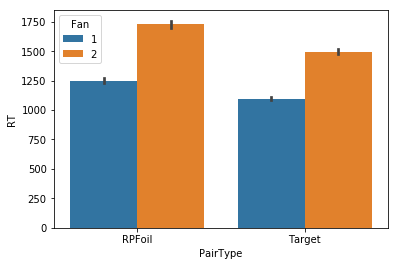

In [7]:
sns.barplot(x="PairType", y="RT", hue="Fan", data=af)

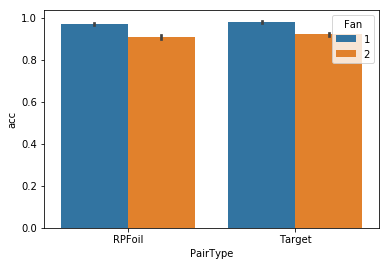

In [8]:
# probably going to need to group by subject
sns.barplot(x="PairType", y="acc", hue="Fan", data=af)

In [48]:
res = af["acc"].groupby([af["Subject"], af["Fan"], af["PairType"]]).apply(lambda g: g.sum()/g.count())

In [63]:
df = pd.DataFrame(res)
df.reset_index(inplace=True)
df['err'] = 1.0-df['acc']
df.head()

,Subject,Fan,PairType,acc,err
0,5,1,RPFoil,0.954751,0.045249
1,5,1,Target,0.972603,0.027397
2,5,2,RPFoil,0.818182,0.181818
3,5,2,Target,0.876147,0.123853
4,9,1,RPFoil,0.990909,0.009091


In [66]:
len(df.Subject.unique())

18

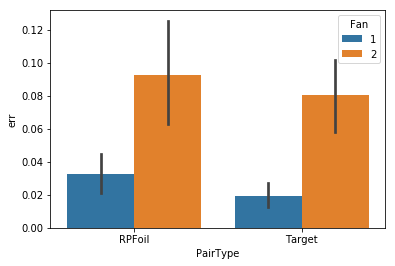

In [65]:
sns.barplot(x="PairType", y="err", hue="Fan", data=df)